# Forecaster explainability: Feature importance, SHAP Values and Partial Dependence Plots

Machine learning explainability refers to the ability to understand, interpret, and explain the decisions or predictions made by machine learning models in a human-understandable way. It aims to shed light on how a model arrives at a particular result or decision.

Due to the complex nature of many modern machine learning models, such as ensemble methods, they often function as black boxes, making it difficult to understand why a particular prediction was made. Explanability techniques aim to demystify these models, providing insight into their inner workings and helping to build trust, improve transparency, and meet regulatory requirements in various domains. Enhancing model explainability not only aids in understanding model behavior but also helps detect biases, improve model performance, and enables stakeholders to make more informed decisions based on machine learning insights.

## Libraries

In [20]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.datasets import fetch_dataset
from sklearn.inspection import PartialDependenceDisplay
import shap
shap.initjs()

## Data


The data used in this example has been obtained from the R tsibbledata package. The dataset contains 5 columns and 52,608 complete records. The information in each column is:

+ Time: date and time of the record.
+ Date: date of the record.
+ Demand: electricity demand (MW).
+ Temperature: temperature in Melbourne, the capital of Victoria.
+ Holiday: indicates if the day is a public holiday.

In [21]:
# Download data
# ==============================================================================
data = fetch_dataset(name="vic_electricity")
data.head(3)

vic_electricity
---------------
Half-hourly electricity demand for Victoria, Australia
O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse
Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,
https://github.com/tidyverts/tsibbledata/.
https://tsibbledata.tidyverts.org/reference/vic_elec.html
Shape of the dataset: (52608, 4)


,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True


In [22]:
# Aggregation to daily frequency
# ==============================================================================
data = data.resample('D').agg({'Demand': 'sum', 'Temperature': 'mean'})
data.head(3)

,Demand,Temperature
Time,,
2011-12-31,82531.745918,21.047727
2012-01-01,227778.257304,26.578125
2012-01-02,275490.988882,31.751042


## Create and train forecaster


A forecasting model is created to predict the energy demand using the past 7 values (last week) and the temperature as an exogenous variable.

In [23]:
# Create a recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123),
                 lags      = 7
             )

forecaster.fit(
    y    = data['Demand'],
    exog = data['Temperature']
)

In [24]:
# Training matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                       y    = data['Demand'],
                       exog = data['Temperature']
                   )

display(X_train.head(3))
display(y_train.head(3))

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,Temperature
Time,,,,,,,,
2012-01-07,205338.714620,211066.426550,213792.376946,258955.329422,275490.988882,227778.257304,82531.745918,24.098958
2012-01-08,200693.270298,205338.714620,211066.426550,213792.376946,258955.329422,275490.988882,227778.257304,20.223958
2012-01-09,200061.614738,200693.270298,205338.714620,211066.426550,213792.376946,258955.329422,275490.988882,19.161458


Time
2012-01-07    200693.270298
2012-01-08    200061.614738
2012-01-09    216201.836844
Freq: D, Name: y, dtype: float64

## Model-specific feature importances

Feature importance is a technique used in machine learning to determine the relevance or importance of each feature (or variable) in a model's prediction. In other words, it measures how much each feature contributes to the model's output.

Feature importance can be used for several purposes, such as identifying the most relevant features for a given prediction, understanding the behavior of a model, and selecting the best set of features for a given task. It can also help to identify potential biases or errors in the data used to train the model. It is important to note that feature importance is not a definitive measure of causality. Just because a feature is identified as important does not necessarily mean that it causes the outcome. Other factors, such as confounding variables, may also be at play.

The method used to calculate feature importance may vary depending on the type of machine learning model being used. Different machine learning models may have different assumptions and characteristics that affect the calculation of feature importance. For example, decision tree-based models such as Random Forest and Gradient Boosting typically use mean decrease impurity or permutation feature importance methods to calculate feature importance. 

Linear regression models typically use coefficients or standardized coefficients to determine the importance of a feature. The magnitude of the coefficient reflects the strength and direction of the relationship between the feature and the target variable.

The importance of the predictors included in a forecaster can be obtained using the method `get_feature_importances()`. This method accesses the `coef_` and `feature_importances_` attributes of the internal regressor.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>
<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px;">
<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b style="color: #ff9100;"> &nbsp Warning</b>
</p>

The <code>get_feature_importances()</code> method will only return values if the forecaster's regressor has either the <code>coef_</code> or <code>feature_importances_</code> attribute, which is the default in scikit-learn. If your regressor does not follow this naming convention, please consider opening an [issue on GitHub](https://github.com/JoaquinAmatRodrigo/skforecast/issues) and we will strive to include it in future updates.

</div>

### Extract feature importances from trained forecaster

In [25]:
# Predictors importances
# ==============================================================================
forecaster.get_feature_importances()

,feature,importance
0,lag_1,471
1,lag_2,377
2,lag_3,345
3,lag_4,311
4,lag_5,295
5,lag_6,319
6,lag_7,347
7,Temperature,535


To properly retrieve the feature importances in the `ForecasterAutoregDirect` and `ForecasterAutoregMultiVariate`, it is essential to specify the model from which to extract the feature importances are to be extracted. This is because [Direct Strategy Forecasters](https://skforecast.org/latest/user_guides/direct-multi-step-forecasting.html) fit one model per step, and each model may have different important features. Therefore, the user must explicitly specify which model's feature importances wish to extract to ensure that the correct features are used.

## Shap Values

SHAP (SHapley Additive exPlanations) values are a popular method for explaining machine learning models, as they help to understand how variables and values influence predictions visually and quantitatively.

It is possible to generate SHAP-values explanations from Skforecast models with just two essential elements:

+ The internal regressor of the forecaster.

+ The training matrices created from the time series and used to fit the forecaster.

By leveraging these two components, users can create insightful and interpretable explanations for their skforecast models. These explanations can be used to verify the reliability of the model, identify the most significant factors that contribute to model predictions, and gain a deeper understanding of the underlying relationship between the input variables and the target variable.

### Shap explainer



The python implementation of [SHAP](https://shap.readthedocs.io/en/latest/index.html) is built along the explainers. These explainers are appropriate only for certain types or classes of algorithms. For example, the TreeExplainer is used for tree-based models.

In [26]:
# Create SHAP explainer
# ==============================================================================
explainer = shap.TreeExplainer(forecaster.regressor)
shap_values = explainer.shap_values(X_train)

### SHAP Summary Plot



The SHAP summary plot typically displays the feature importance or contribution of each feature to the model's output across multiple data points. It shows how much each feature contributes to pushing the model's prediction away from a base value (often the model's average prediction). By examining a SHAP summary plot, one can gain insights into which features have the most significant impact on predictions, whether they positively or negatively influence the outcome, and how different feature values contribute to specific predictions.

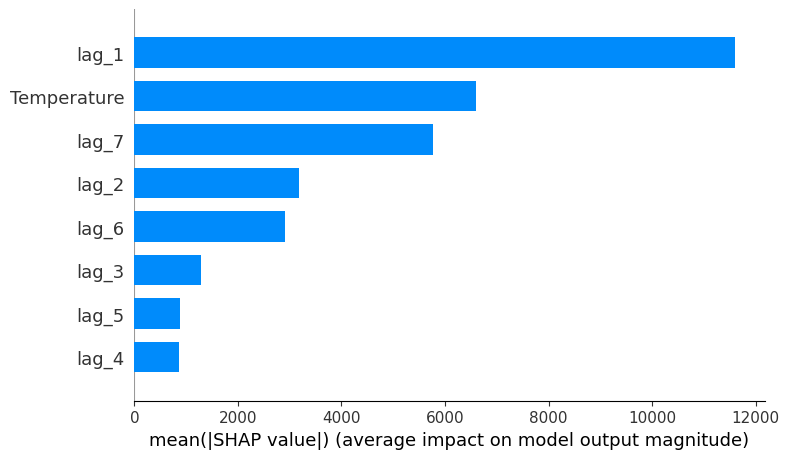

In [27]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

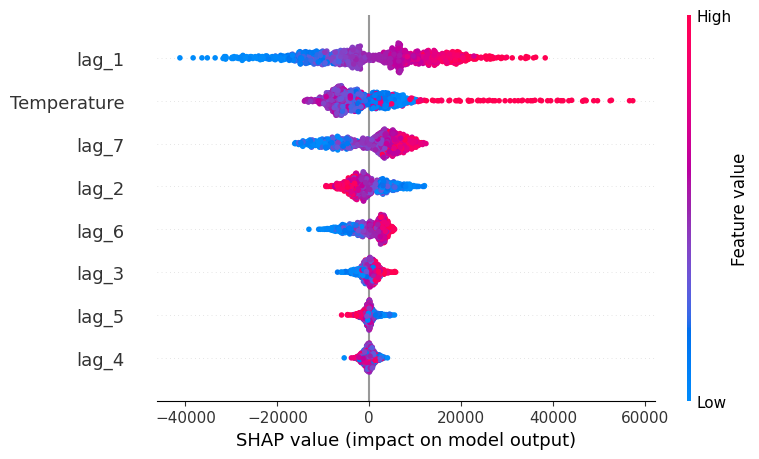

In [28]:
shap.summary_plot(shap_values, X_train)

### Explain individual predictions


A `shap.force_plot` is a specific type of visualization that provides an interactive and detailed view of how individual features contribute to a particular prediction made by a machine learning model. It's a local interpretation tool that helps understand why a model made a specific prediction for a given instance.

**Visualize a single prediction**

In [29]:
# Force plot for the first observation
# ==============================================================================
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

**Visualize many predictions**

In [30]:
# Force plot for the first 200 observations in the training set
# ==============================================================================
shap.force_plot(explainer.expected_value, shap_values[:200,:], X_train.iloc[:200,:])

### SHAP Dependence Plots


SHAP dependence plots are visualizations used to understand the relationship between a feature and the model output by displaying how the value of a single feature affects predictions made by the model while considering interactions with other features. These plots are particularly useful for examining how a certain feature impacts the model's predictions across its range of values while considering interactions with other variables. 

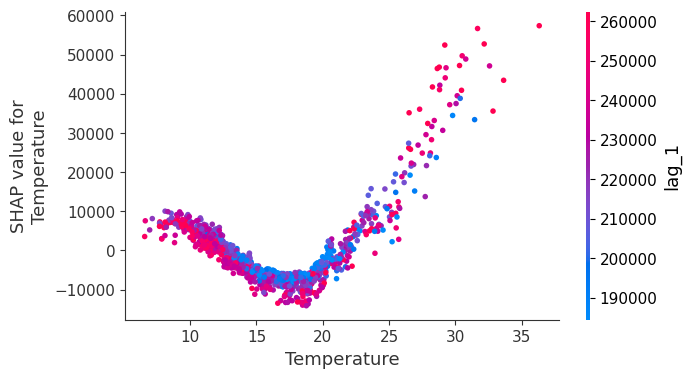

In [31]:
# Dependence plot for Temperature
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 4))
shap.dependence_plot("Temperature", shap_values, X_train, ax=ax)

## Scikit-learn partial dependence plots

Partial dependence plots (PDPs) are a useful tool for understanding the relationship between a feature and the target outcome in a machine learning model. In scikit-learn, you can create partial dependence plots using the `plot_partial_dependence` function. This function visualizes the effect of one or two features on the predicted outcome, while marginalizing the effect of all other features.

The resulting plots show how changes in the selected feature(s) affect the predicted outcome while holding other features constant on average. Remember that these plots should be interpreted in the context of your model and data. They provide insight into the relationship between specific features and the model's predictions.

A more detailed description of the Partial Dependency Plot can be found in <a href="https://scikit-learn.org/stable/modules/partial_dependence.html#partial-dependence-and-individual-conditional-expectation-plots">Scikitlearn&#39;s User Guides</a>.

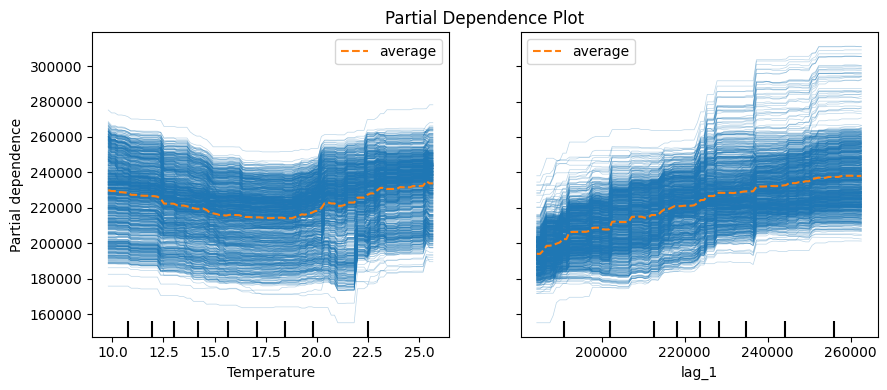

In [32]:
# Scikit-learn partial dependence plots
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
ax.set_title("Decision Tree")
pd.plots = PartialDependenceDisplay.from_estimator(
    estimator = forecaster.regressor,
    X         = X_train,
    features  = ["Temperature", "lag_1"],
    kind      = 'both',
    ax        = ax,
)
ax.set_title("Partial Dependence Plot")
fig.tight_layout();